## <font style="color:green">1. Data Loader</font>

In this section, Implementing Dataloader class to get training and validation data loader.


In [1]:
%matplotlib inline
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# from torchvision.transforms import functional as F



import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

from torch.optim import lr_scheduler

from torch.utils.tensorboard import SummaryWriter


import matplotlib.pyplot as plt

from typing import Iterable
from dataclasses import dataclass

import os
import numpy as np
import pandas as pd
import math

from PIL import Image

In [3]:
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image

class KenyanFood13Dataset(Dataset):

    def __init__(self, data_root, train=True, image_shape=None, transform=None):

        """
        init method of the class.
         Parameters:
         data_root (string): path of root directory.
         train (boolean): True for training dataset and False for test dataset.
         image_shape (int or tuple or list): [optional] int or tuple or list. Defaut is None.
                                             If it is not None image will resize to the given shape.
         transform (method): method that will take PIL image and transform it.
        """

        # get label to species mapping
        train_csv_path = os.path.join(data_root, 'train.csv')

        # random.seed(21)

        pd_csv = pd.read_csv(train_csv_path)

        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)

            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError

        else:
            self.image_shape = image_shape

        # set transform attribute
        self.transform = transform

        unique_classes = pd_csv["class"].unique()

        num_classes = len(unique_classes)

        classes_pd = pd_csv["class"]
        image_paths = pd_csv["id"]
        self.classes, counter = {}, 0
        for uclass in unique_classes:
            self.classes[uclass] = counter
            counter += 1

        # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': []
        }

        image_classes = [[] for _ in range(len(unique_classes))]
        for ind, path in enumerate(image_paths):
            image_classes[self.classes[classes_pd[ind]]].append(path)

        im_path = os.path.join(data_root,'images','images')

        for c, image_class in enumerate(image_classes):
            X_train, X_test, y_train, y_test = train_test_split(image_class, [c]*len(image_class), test_size=0.20, random_state=23)
            if train:
                X, y = X_train, y_train
            else:
                X, y = X_test, y_test
            for im in X:
                self.data_dict['image_path'].append(os.path.join(im_path, str(im)+'.jpg'))
                self.data_dict['label'].append(c)

    def __len__(self):
        """
        return length of the dataset
        """
        return len(self.data_dict['label'])


    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """

        image = Image.open(self.data_dict['image_path'][idx]).convert("RGB")

        # if self.image_shape is not None:
        #     image = F.resize(image, self.image_shape)

        if self.transform is not None:
            image = self.transform(image)

        target = self.data_dict['label'][idx]

        return image, target

In [7]:
def data_loader(train, transforms, batch_size, shuffle, num_workers,data_augmentation=True):
    dataset = KenyanFood13Dataset(data_root = data_root, train = train, image_shape=256, transform= transforms)
    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size = batch_size,
                                         num_workers = num_workers,
                                         shuffle = shuffle)
    return loader

def get_mean_std():
    mean, std = [ 0.4837,  0.1418, -0.1151], [1.2656, 1.3080, 1.3844]
    return (mean, std)

def get_data(batch_size, data_root, num_workers = 1, data_augmentation=True):
    #common transorms
    mean, std = get_mean_std()
    common_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ])
    train_transforms = common_transforms
    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ColorJitter(brightness = 0.6),
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(20, fill=(0,0,0)),
                transforms.RandomCrop(224, padding=4),
                transforms.RandomAffine(30, translate=(0.3,0.3),
                                        scale=(0.8, 1.2), shear=None)
            ]),

            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    train_loader = data_loader(train = True, transforms = train_transforms, batch_size = batch_size, shuffle = True, num_workers= num_workers,data_augmentation=True)
    test_loader = data_loader(train = False, transforms = common_transforms, batch_size = batch_size, shuffle = False, num_workers=num_workers,data_augmentation=True)

    return train_loader, test_loader

Length of the dataset: 5224
Label: 0


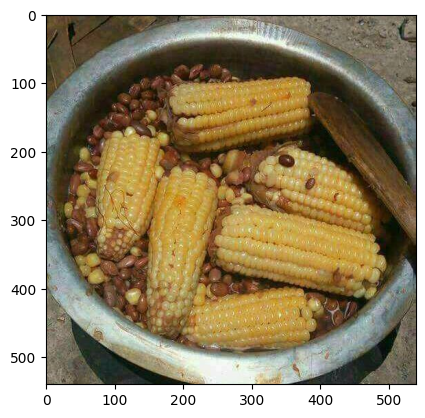

Label: 0


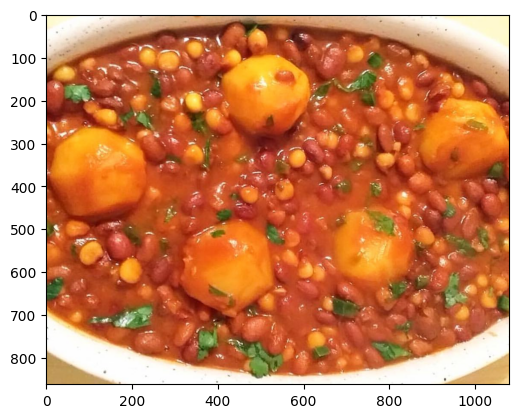

Label: 0


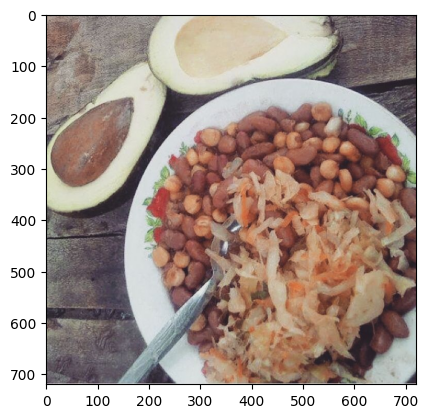

Label: 0


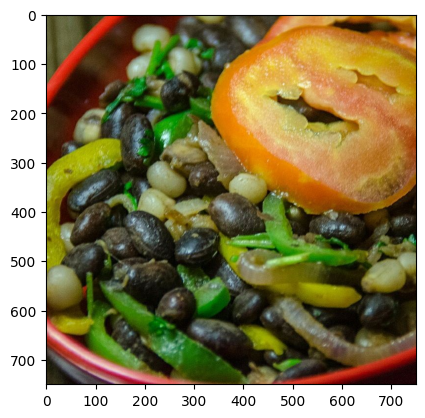

Label: 0


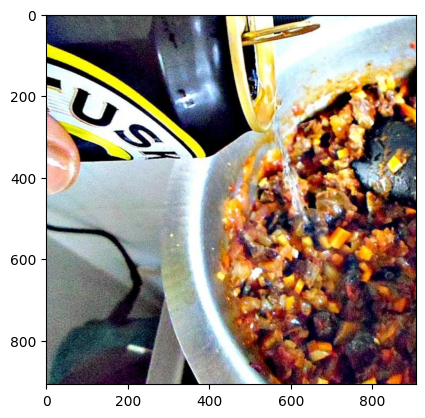

Label: 0


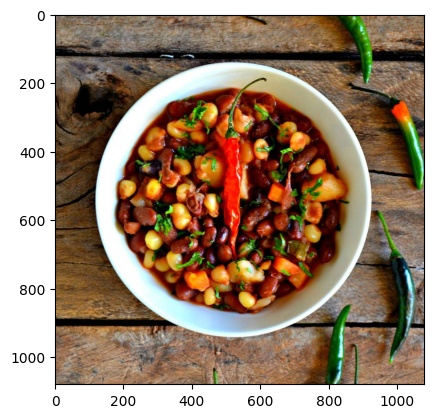

Label: 0


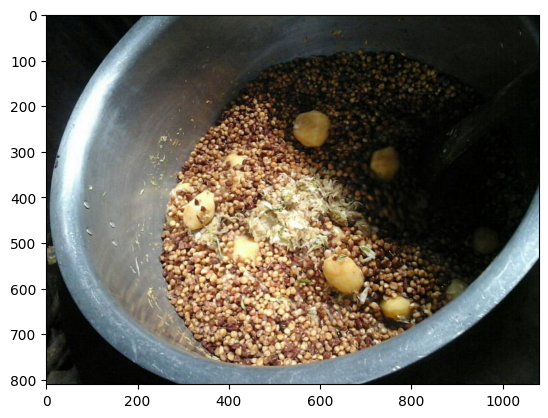

Label: 0


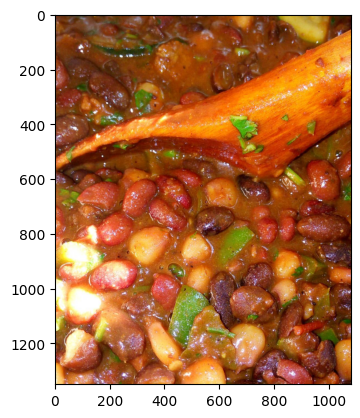

Label: 0


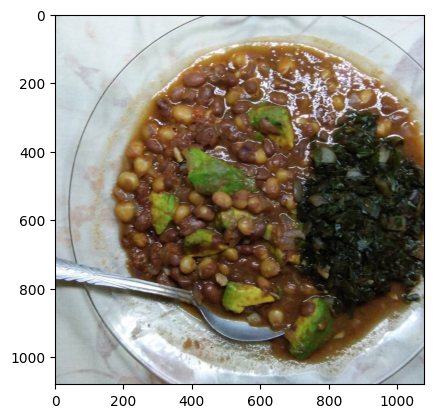

Label: 0


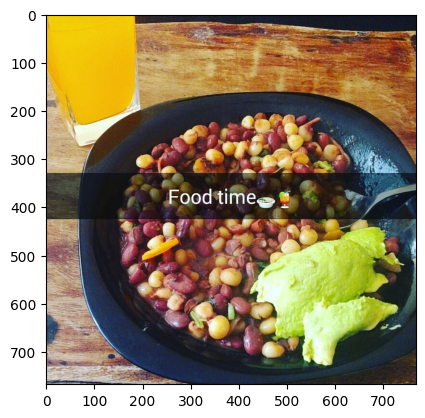

Label: 0


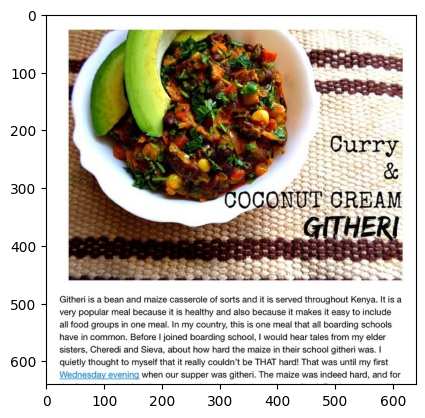

Label: 0


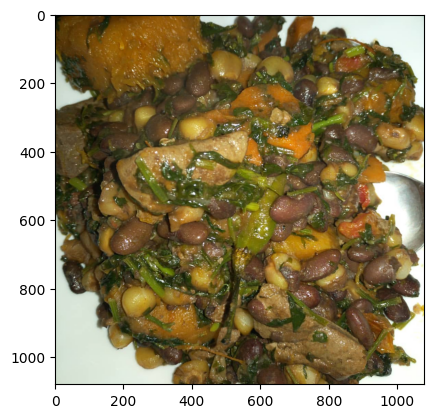

Label: 0


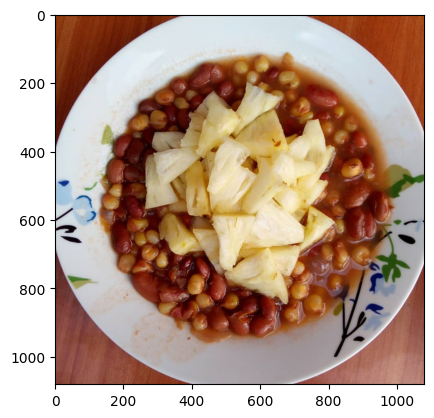

Label: 0


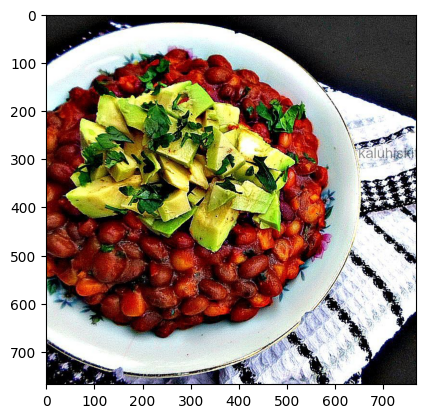

Label: 0


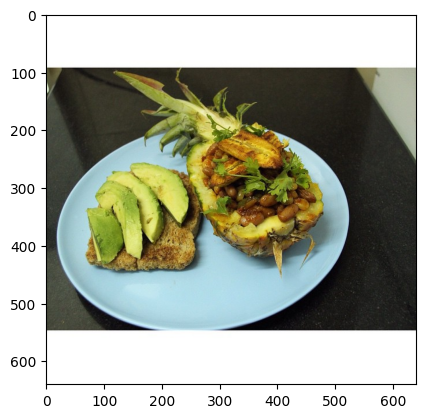

In [8]:
data_root = r'/kaggle/input/opencv-pytorch-classification-project-2'
train_dataset = KenyanFood13Dataset(data_root, train = True, image_shape = 256)
print('Length of the dataset: {}'.format(len(train_dataset)))
for i in range(15):
    img, trgt = train_dataset[100+i]
    print('Label: {}'.format(trgt))
    plt.imshow(img)
    plt.show()

## <font style="color:green">2. Configuration</font>

In [10]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 60  
    init_learning_rate: float = 0.0001  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = r"/kaggle/input/opencv-pytorch-classification-project-2" 
    num_workers: int = 8 
    device: str = 'cuda'

In [11]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [12]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:green">3. Evaluation Metric</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

In [14]:
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir=log_resnet50/transfer_learning

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## <font style="color:green">4. Train and Validation</font>


**Write the methods or classes to be used for training and validation.**

In [15]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int, tb_writer: SummaryWriter
) -> None:

    # change model in training mood
    model.train()

    # to get batch loss
    batch_loss = np.array([])

    # to get batch accuracy
    batch_acc = np.array([])

    for batch_idx, (data, target) in enumerate(train_loader):

        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()

        # forward pass to the model
        output = model(data)
        # print(output.size(), 'from train output.size()')
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        # loss = Variable(loss, requires_grad = True)
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()

        batch_loss = np.append(batch_loss, [loss.item()])

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()

        # accuracy
        acc = float(correct) / float(len(data))

        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:
            
            total_batch = epoch_idx * len(train_loader.dataset)/train_config.batch_size + batch_idx
            tb_writer.add_scalar('Loss/train-batch', loss.item(), total_batch)
            tb_writer.add_scalar('Accuracy/train-batch', acc, total_batch)

    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    tb_writer.add_scalar('Loss/train', epoch_loss.item(), total_batch)
    tb_writer.add_scalar('Accuracy/train', epoch_acc.item(), total_batch)
    
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [16]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    #
    model.eval()
    test_loss = 0
    output = None
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)

        target = target.to(train_config.device)

        with torch.no_grad():
            output = model(data)

        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)

    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )

    return test_loss, accuracy/100.0

In [18]:
import time

def main(model, optimizer, tb_writer, scheduler=None, system_configuration=SystemConfiguration(),
         training_configuration=TrainingConfiguration(), data_augmentation=True):

    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config,
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )

    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)

    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])

    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss,
                                                                                   init_val_accuracy*100))

    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):

        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch, tb_writer)

        epoch_train_loss = np.append(epoch_train_loss, [train_loss])

        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time

        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)

            epoch_test_loss = np.append(epoch_test_loss, [current_loss])

            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])

            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_accuracy, epoch)
            
            # add scalars (loss/accuracy) to tensorboard
            tb_writer.add_scalars('Loss/train-val', {'train': train_loss, 
                                           'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': train_acc, 
                                               'validation': current_accuracy}, epoch)

            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)

            # scheduler step/ update learning rate
        if scheduler is not None:
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(current_loss)
                print("Bad Epochs:{}".format(scheduler.num_bad_epochs))
                print("last LR = {}".format(scheduler._last_lr))
            else:
                scheduler.step()


    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [19]:
def get_optimizer_and_scheduler(model):
    train_config = TrainingConfiguration()

    init_learning_rate = train_config.init_learning_rate

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr = init_learning_rate,
        momentum = 0.9
    )

    factor = 0.5  # reduce by factor 0.5
    patience = 2  # epochs
    threshold = 0.1
    verbose = True
    
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=verbose, threshold=threshold)
    
    return optimizer, scheduler

In [20]:
def save_model(model, device, model_dir='models', model_file_name='KenyanFood_classifier_resnet50.pt'):


    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)

    if device == 'cuda':
        model.to('cuda')

    return

## <font style="color:green">5. Model</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

In [21]:
def pretrained_resnet50(transfer_learning=True, num_class=13):
    resnet = models.resnet50(pretrained=True)
    
    if transfer_learning:
        for param in resnet.parameters():
            param.requires_grad = False
            
    last_layer_in = resnet.fc.in_features
    resnet.fc = nn.Sequential(
        nn.Linear(last_layer_in, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 13))
    
    return resnet

In [22]:
resnet = pretrained_resnet50()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


In [23]:
for params in resnet.layer1.parameters():
    params.requires_grad = True

for params in resnet.layer2.parameters():
    params.requires_grad = True

for params in resnet.layer3.parameters():
    params.requires_grad = True

for params in resnet.layer4.parameters():
    params.requires_grad = True

for params in resnet.fc.parameters():
    params.requires_grad = True

In [24]:
optimizer, scheduler = get_optimizer_and_scheduler(resnet)

transfer_learning_sw = SummaryWriter('log_resnet50/transfer_learning')

model, train_loss_exp2, train_acc_exp2, val_loss_exp2, val_acc_exp2 = main(resnet, optimizer, transfer_learning_sw, scheduler, data_augmentation=True)

transfer_learning_sw.close()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoa


Test set: Average loss: 2.5758, Accuracy: 114/1312 (9%)

Initial Test Loss : 2.575809, 
Initial Test Accuracy : 8.689%

Epoch: 0 
Train Loss: 2.464675 Acc: 0.1737
Elapsed 65.23s, 65.23 s/epoch, 0.12 s/batch, ets 3848.35s

Test set: Average loss: 2.3691, Accuracy: 318/1312 (24%)

Model Improved. Saving the Model...

Bad Epochs:0
last LR = [0.0001]
Epoch: 1 
Train Loss: 2.298438 Acc: 0.2818
Elapsed 140.25s, 70.12 s/epoch, 0.13 s/batch, ets 4067.21s

Test set: Average loss: 2.1172, Accuracy: 520/1312 (40%)

Model Improved. Saving the Model...

Bad Epochs:0
last LR = [0.0001]
Epoch: 2 
Train Loss: 2.040830 Acc: 0.3892
Elapsed 215.06s, 71.69 s/epoch, 0.14 s/batch, ets 4086.18s

Test set: Average loss: 1.8061, Accuracy: 628/1312 (48%)

Model Improved. Saving the Model...

Bad Epochs:0
last LR = [0.0001]
Epoch: 3 
Train Loss: 1.817994 Acc: 0.4497
Elapsed 290.53s, 72.63 s/epoch, 0.14 s/batch, ets 4067.40s

Test set: Average loss: 1.5927, Accuracy: 708/1312 (54%)

Model Improved. Saving the Mo

## <font style="color:green">6. Utils</font>

**Define those methods or classes, which have  not been covered in the above sections.**

In [ ]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left',
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()

    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = train_loss[i].min()

        min_val_loss = val_loss[i].min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID LOSS ({0:.4})".format(min_val_loss))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = train_acc[i].max()

        max_val_acc = val_acc[i].max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ACC ({0:.4})".format(max_val_acc))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')

    fig.savefig('sample_loss_acc_plot.png')
    plt.show()

    return

In [ ]:
plot_loss_accuracy(train_loss=[train_loss_exp2],
                   val_loss=[val_loss_exp2],
                   train_acc=[train_acc_exp2],
                   val_acc=[val_acc_exp2],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

## <font style="color:green">7. Experiment</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "densenet"

# Number of classes in the dataset
num_classes = 13

# Batch size for training (change depending on how much memory you have)
batch_size = 4

# Number of epochs to train for 
num_epochs = 75

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        
        model_ft.fc =  nn.Sequential(nn.Dropout(0.1),
                                     nn.Linear(num_ftrs,num_classes)
                                     )
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
      
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)


In [ ]:
def save_model(model, device, model_dir='models', model_file_name='KenyanFood_classifier_resnet34.pt'):


    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)

    if device == 'cuda':
        model.to('cuda')

    return

In [ ]:
def pretrained_resnet34(num_class=13):
    model = models.resnet34(pretrained=True)

    count=0
    for child in model.children():
        count+=1
        if count<=7:
            for param in child.parameters():
                param.requires_grad = False



    last_layer_in = model.fc.in_features
    model.fc = nn.Linear(last_layer_in, num_class)


    return model

In [ ]:
model = pretrained_resnet34()
print(model)

# get optimizer
train_config = TrainingConfiguration()



# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate, weight_decay = 0.01
)

decay_rate = 0.01

lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

# Scheduler
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)

In [ ]:
scheduler = get_optimizer_and_scheduler(model)
fine_tuning_sw = SummaryWriter('logs_kenyan_food_resnet34')

model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, fine_tuning_sw, scheduler=scheduler, data_augmentation=True)

fine_tuning_sw.close()

In [ ]:
plot_loss_accuracy(train_loss=[train_loss],
                   val_loss=[val_loss],
                   train_acc=[train_acc],
                   val_acc=[val_acc],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

In [ ]:
def save_model(model, device, model_dir='models', model_file_name='KenyanFood_classifier_densenet121.pt'):


    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)

    if device == 'cuda':
        model.to('cuda')

    return

In [ ]:
def pretrained_densenet121(num_class=13):
    model = models.densenet121(pretrained=True)

    count=0
    for child in model.children():
        count+=1
        if count<=7:
            for param in child.parameters():
                param.requires_grad = False



    last_layer_in = model.classifier.in_features
    model.classifier = nn.Linear(last_layer_in, num_class)


    return model

In [ ]:
model = pretrained_densenet121()
print(model)

# get optimizer
train_config = TrainingConfiguration()



# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate, weight_decay = 0.01
)

decay_rate = 0.01

lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

# Scheduler
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)

In [ ]:
scheduler = get_optimizer_and_scheduler(model)
fine_tuning_sw = SummaryWriter('logs_kenyan_food_densenet121')


model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, fine_tuning_sw, scheduler=scheduler, data_augmentation=True)

fine_tuning_sw.close()

In [ ]:
plot_loss_accuracy(train_loss=[train_loss],
                   val_loss=[val_loss],
                   train_acc=[train_acc],
                   val_acc=[val_acc],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')